In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import utils

from data_utils import CustomDataset
from MLP_utils import SimpleMLP, LNLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

In [23]:
filenames_features = [utils.FILENAME_BRAND_OHE,
utils.FILENAME_PUBLICATION_TIMESTAMP,
utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
utils.FILENAME_NUM_WORDS,
utils.FILENAME_NUM_PARAGRAPH,
# utils.FILENAME_MAIN_SECTION_EMB,
# utils.FILENAME_SUBSECTIONS_OHE,
# utils.FILENAME_SUBSECTIONS_OHE,
# utils.FILENAME_SUBSECTIONS_EMB,
utils.FILENAME_MAIN_SECTION_SUBSECTIONS_MEAN_EMB,
utils.FILENAME_USER_NEEDS,
utils.FILENAME_LDA_TOPICS,
utils.FILENAME_IPTC_TOPICS_LEVEL_0,
utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS

brands = ["parool"]

dataset = CustomDataset(brands, 
                        filenames_features, 
                        dirpath_extracted_features=DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=False, 
                        center_target=False,
                        filter_uniform_features=False, 
                        max_datapoints=None)
dataset.features.shape

torch.Size([7729, 473])

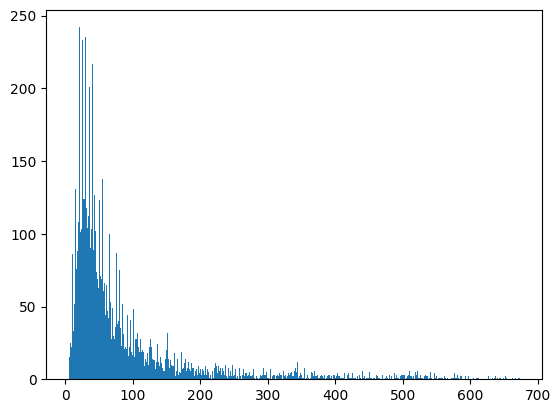

In [24]:
plt.hist(dataset.target.cpu(), bins=len(dataset.target.unique()))
plt.show()

In [17]:
batch_size = 1024 
balanced_sampling_training = False
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
EPOCHS = 200
train_loss = []
test_loss = []
model = SimpleMLP(input_size=dataset.features.shape[1], hidden_sizes=[128, 128], output_size=1, batchnorm=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

eval_per_n_batches = 5

loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
# loss_fn = LNLoss(4)


for epoch in range(EPOCHS):

    model.train(True)
    
    running_loss = 0.

    for i, data in enumerate(train_dataloader):
        model.train(True)
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % eval_per_n_batches == (eval_per_n_batches-1):
            avg_loss = running_loss / eval_per_n_batches 
            train_loss.append(avg_loss)

            running_loss = 0.

            running_vloss = 0.0

            model.eval()
            with torch.no_grad():
                for i, vdata in enumerate(test_dataloader):
                    vinputs, vlabels = vdata
                    voutputs = model(vinputs)
                    vloss = loss_fn(voutputs, vlabels)
                    running_vloss += vloss 

            avg_vloss = running_vloss / len(test_dataloader)
            test_loss.append(avg_vloss.item())
    print(f"finished epoch {epoch+1}/{EPOCHS} with eval loss {test_loss[-1]:.3f}")

finished epoch 1/200 with eval loss 0.889
finished epoch 2/200 with eval loss 0.832
finished epoch 3/200 with eval loss 0.813
finished epoch 4/200 with eval loss 0.803
finished epoch 5/200 with eval loss 0.797
finished epoch 6/200 with eval loss 0.792
finished epoch 7/200 with eval loss 0.788
finished epoch 8/200 with eval loss 0.783
finished epoch 9/200 with eval loss 0.778
finished epoch 10/200 with eval loss 0.777
finished epoch 11/200 with eval loss 0.775
finished epoch 12/200 with eval loss 0.775
finished epoch 13/200 with eval loss 0.768
finished epoch 14/200 with eval loss 0.770
finished epoch 15/200 with eval loss 0.765
finished epoch 16/200 with eval loss 0.762
finished epoch 17/200 with eval loss 0.759
finished epoch 18/200 with eval loss 0.759
finished epoch 19/200 with eval loss 0.752
finished epoch 20/200 with eval loss 0.748
finished epoch 21/200 with eval loss 0.747
finished epoch 22/200 with eval loss 0.734
finished epoch 23/200 with eval loss 0.734
finished epoch 24/20

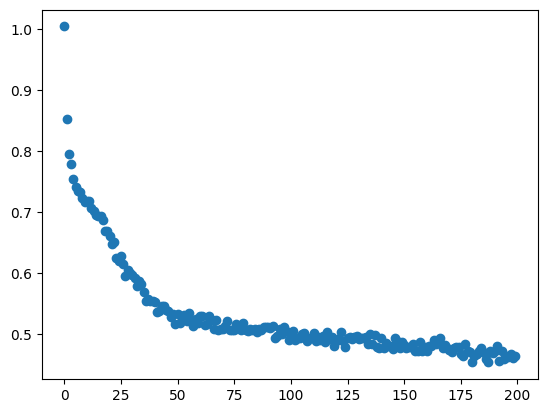

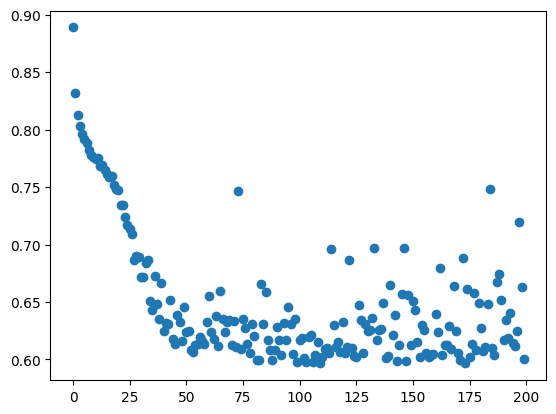

In [19]:
plt.scatter(range(len(train_loss)), train_loss)
plt.show()
plt.scatter(range(len(test_loss)), test_loss)
plt.show()

In [20]:
with torch.no_grad():
    model.eval()
    metric = nn.MSELoss(reduction='none')
    y_train = dataset[train_dataset.indices][1].cpu()
    y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
    abs_dif_train = metric(y_pred_train, y_train)

    y_test = dataset[test_dataset.indices][1].cpu()
    y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
    abs_dif_test = metric(y_pred_test, y_test)

tensor(0.4832) tensor(0.9177)
tensor(0.6403) tensor(1.1281)


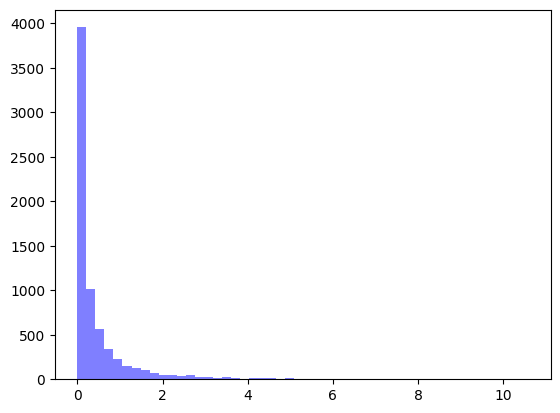

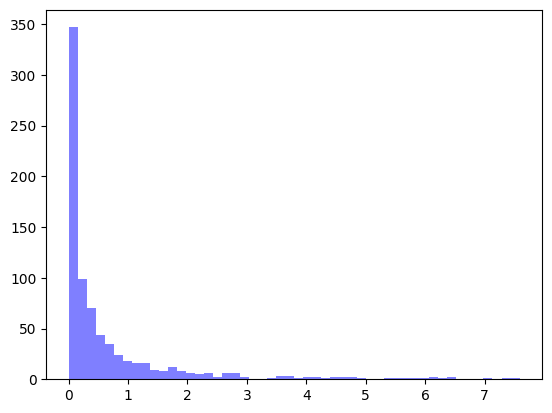

In [21]:
print(abs_dif_train.mean(), abs_dif_train.std())
print(abs_dif_test.mean(), abs_dif_test.std())
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.show()

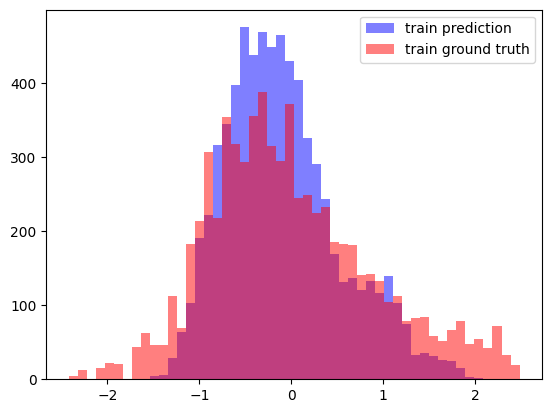

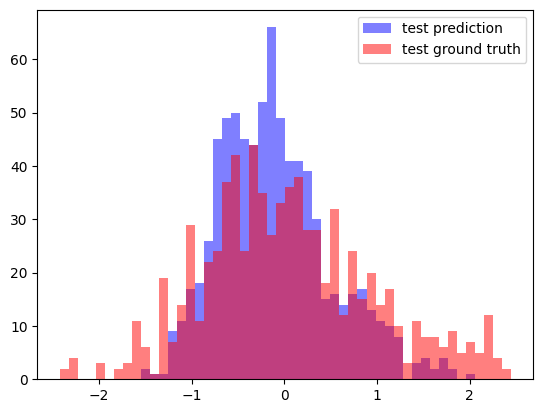

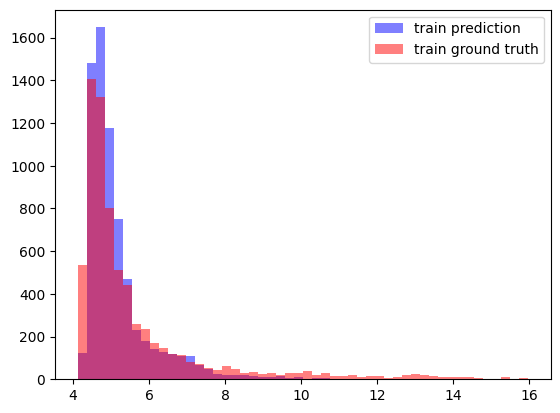

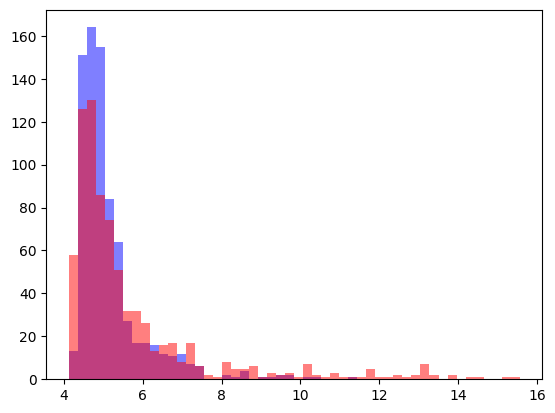

In [22]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

y_pred_train_trans = y_pred_train
y_train_trans = y_train
y_pred_test_trans = y_pred_test
y_test_trans = y_test
if dataset.log_target:
    y_pred_train_trans = torch.exp(y_pred_train_trans)
    y_train_trans = torch.exp(y_train_trans)
    y_pred_test_trans = torch.exp(y_pred_test_trans)
    y_test_trans = torch.exp(y_test_trans)
if dataset.center_target:
    centering_shift = dataset.centering_shift.cpu()
    y_pred_train_trans = y_pred_train_trans + centering_shift
    y_train_trans = y_train_trans + centering_shift
    y_pred_test_trans = y_pred_test_trans + centering_shift
    y_test_trans = y_test_trans + centering_shift
if not dataset.log_target:
    y_pred_train_trans = torch.log(y_pred_train_trans)
    y_train_trans = torch.log(y_train_trans)
    y_pred_test_trans = torch.log(y_pred_test_trans)
    y_test_trans = torch.log(y_test_trans)


bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r')
plt.show()